In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.8.2


In [2]:
df = pd.read_csv('../data/H1.csv')

In [3]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df['YearWeek'] = df['ArrivalDateYear'].map(str) + '-' + df['ArrivalDateWeekNumber'].map(str)

In [5]:
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,YearWeek
0,0,342,2015,July,27,1,0,0,2,0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-27
1,0,737,2015,July,27,1,0,0,2,0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-27
2,0,7,2015,July,27,1,0,1,1,0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-27
3,0,13,2015,July,27,1,0,1,1,0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-27
4,0,14,2015,July,27,1,0,2,2,0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-27


<AxesSubplot:xlabel='YearWeek'>

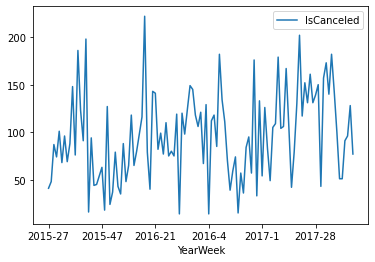

In [6]:
df.groupby(['YearWeek']).agg({'IsCanceled':'sum'}).plot()

In [7]:
canceled_ts = df.groupby(['YearWeek']).agg({'IsCanceled':'sum'}).reset_index()
canceled_ts.head()

,YearWeek,IsCanceled
0,2015-27,41
1,2015-28,48
2,2015-29,87
3,2015-30,74
4,2015-31,101


In [8]:
canceled_ts.describe()

,IsCanceled
count,115.000000
mean,96.713043
std,45.865510
min,14.000000
25%,64.000000
50%,95.000000
75%,127.500000
max,222.000000


In [9]:
# Adding Year Week Monday date as datetime index to pandas
# dt_format = '%Y-%W%w'
# canceled_ts['YearWeekMonday'] = pd.to_datetime(canceled_ts.index + '1', format='%Y-%W%w')
# canceled_ts['YearWeek'] = canceled_ts.index
# canceled_ts = canceled_ts.set_index(pd.DatetimeIndex(canceled_ts['YearWeekMonday']))

In [10]:
canceled_ts.head()

,YearWeek,IsCanceled
0,2015-27,41
1,2015-28,48
2,2015-29,87
3,2015-30,74
4,2015-31,101


<AxesSubplot:>

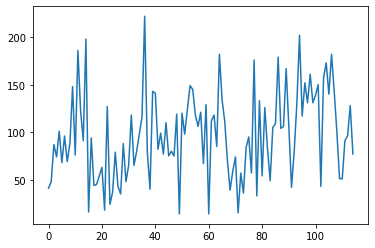

In [11]:
canceled_ts['IsCanceled'].plot()

In [12]:
canceled_ts.index

RangeIndex(start=0, stop=115, step=1)

In [13]:
(canceled_ts['IsCanceled']).name

'IsCanceled'

# Decompose time series into trend, seasonal and residuals

In [16]:
decompose_result = seasonal_decompose(canceled_ts['IsCanceled'], period=52)

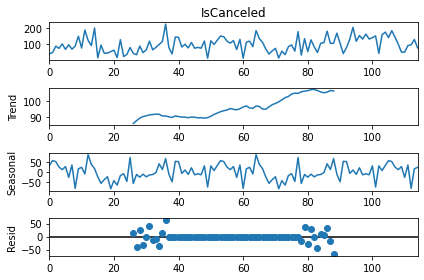

In [17]:
decompose_result.plot()
plt.show()

# ACF and PACF

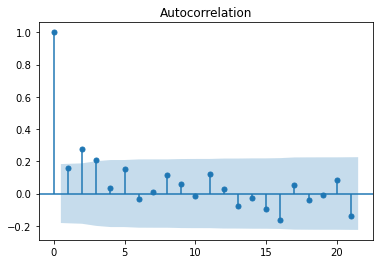

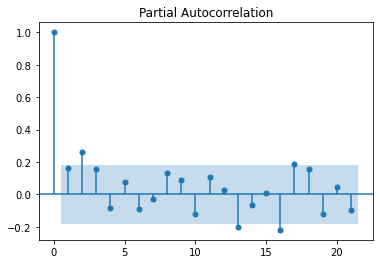

In [19]:
plot_acf(canceled_ts['IsCanceled'])
plot_pacf(canceled_ts['IsCanceled'])

plt.show()

# SMA Window size 4

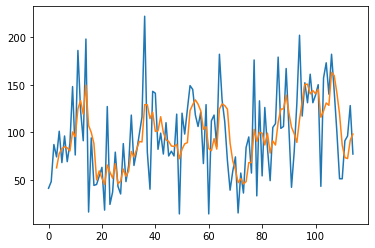

In [20]:
canceled_ts['IsCanceled'].plot()
canceled_ts['IsCanceled'].rolling(window=4).mean().plot()
plt.show()

# Split Time series 90/10

In [21]:
def ts_split(ts_series, test_size =0.10):
    'return train, test'
    test_len = int(test_size * len(canceled_ts['IsCanceled']))
    return ts_series[:-test_len], ts_series[-test_len:]

In [23]:
train_ts, test_ts = ts_split(canceled_ts['IsCanceled'])

In [24]:
len(train_ts), len(test_ts), len(canceled_ts['IsCanceled'])

(104, 11, 115)

# Auto Arima

In [26]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [27]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train_ts, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_ts, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [36]:
#auto arima
auto = pm.auto_arima(train_ts, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True, information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1103.803, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1149.021, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1107.214, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1092.142, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1144.421, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1095.605, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1096.173, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1100.003, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1088.097, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1091.222, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=1091.844, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=1102.632, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=1095.665, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.753 seconds


In [37]:
print (auto.order)

(0, 1, 1)


In [38]:
model = auto

# Multi-Step Forecast

In [39]:
fc, conf_int = model.predict(n_periods=len(test_ts), return_conf_int=True)

In [40]:
fc

array([125.958652, 125.958652, 125.958652, 125.958652, 125.958652,
       125.958652, 125.958652, 125.958652, 125.958652, 125.958652,
       125.958652])

In [41]:
conf_int

array([[ 37.29000797, 214.62729604],
       [ 36.2495656 , 215.6677384 ],
       [ 35.22105268, 216.69625132],
       [ 34.20406804, 217.71323596],
       [ 33.1982325 , 218.7190715 ],
       [ 32.20318724, 219.71411677],
       [ 31.21859226, 220.69871175],
       [ 30.24412506, 221.67317895],
       [ 29.2794794 , 222.63782461],
       [ 28.32436415, 223.59293985],
       [ 27.37850232, 224.53880168]])

In [48]:
print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, fc))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, fc)}")

Root Mean squared error: 44.99826625237395
Ave test set: 112.0
Ave train set: 95.09615384615384
SMAPE: 35.689477371663926


# One-step out Forecast

In [64]:
model.predict?

In [54]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test_ts:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Root Mean squared error: {np.sqrt(mean_squared_error(test_ts, forecasts))}")
print(f"Ave test set: {np.mean(test_ts)}")
print(f"SMAPE: {smape(test_ts, forecasts)}")

Root Mean squared error: 45.24842791095522
Ave test set: 112.0
SMAPE: 35.796591106229144


In [58]:
test_ts

104    173
105    140
106    182
107    143
108    100
109     51
110     51
111     91
112     96
113    128
114     77
Name: IsCanceled, dtype: int64

In [59]:
forecasts

[101.19091719468929,
 112.22168258683527,
 115.96681061563086,
 125.68386544681363,
 128.94600026568833,
 123.87881527646249,
 114.15326909285096,
 106.00147733054473,
 103.60942078943236,
 102.37696240407504,
 106.26084239511597]

In [65]:
confidence_intervals

[[12.966949870768019, 189.41488451861056],
 [23.629810032397188, 200.81355514127335],
 [27.477766136084114, 204.4558550951776],
 [36.789713300278606, 214.57801759334865],
 [40.33326171639696, 217.55873881497968],
 [35.44857686214675, 212.30905369077823],
 [25.320532032650036, 202.9860061530519],
 [16.80791399686578, 195.19504066422368],
 [14.701564525428367, 192.51727705343637],
 [13.788616243319794, 190.9653085648303],
 [17.897506277939854, 194.62417851229208]]

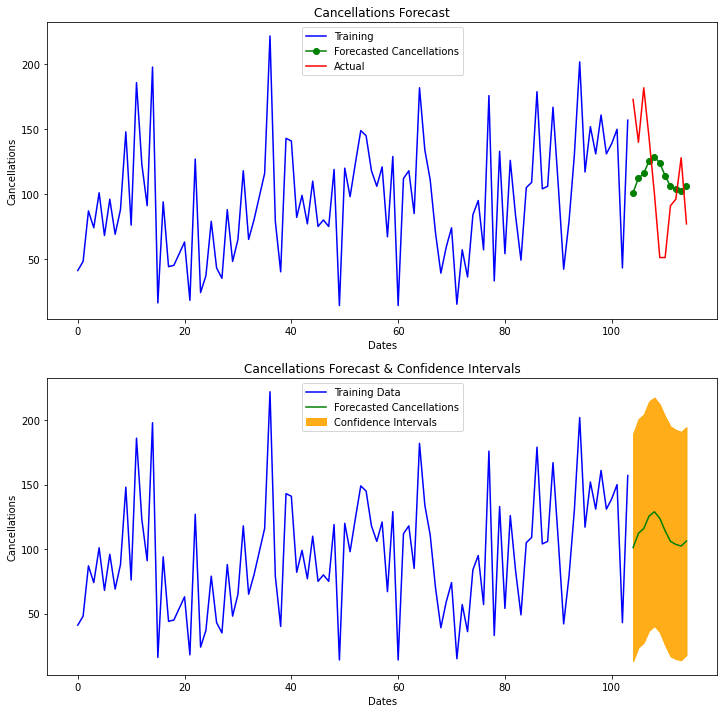

In [63]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train_ts, color='blue', label='Training')
axes[0].plot(test_ts.index, forecasts, color='green', marker='o',
             label='Forecasted Cancellations')

axes[0].plot(test_ts.index, test_ts, color='red', label='Actual')
axes[0].set_title('Cancellations Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Cancellations')

#axes[0].set_xticks(np.arange(0, 114, 1).tolist(), canceled_ts['YearWeek'][0:120:1].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train_ts, color='blue', label='Training Data')
axes[1].plot(test_ts.index, forecasts, color='green',
             label='Forecasted Cancellations')

axes[1].set_title('Cancellations Forecast & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Cancellations')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_ts.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

#axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()